In [102]:
import lammps2d as lmp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import trackpy as tp

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [192]:

temp = 300 # K
Kb = 4/300 # pN nm / K
diffusion = 0.1e6 #nm^2/s
drag = Kb*temp/diffusion #pN/(nm/s)

def hi_level(height = 5, angle = 90, frequency = 10):
    initial_positions = np.array([[-1.41,0,0.1],[1.41,0,-0.1]])

    sim = lmp.sim(initial_positions,
                  magnitude = 3,
                  radius = 1.4,
                  drag = drag,
                  frequency=frequency,
                  susceptibility = 0.5,
                  angle=angle,
                  lj_parameters=[1,1/(2**(1/6))],
                  lj_cutoff = 1,
                  framerate=1e1,
                  timestep=1e-4,
                  total_time = 10,
                  walls = [-height/2,height/2],
                  temperature = 1)
    sim.generate_scripts()
    sim.run()

    return sim

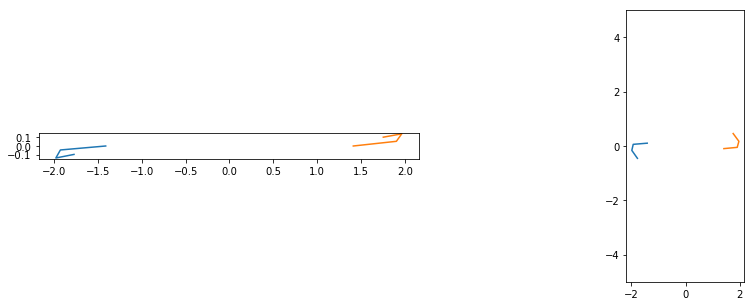

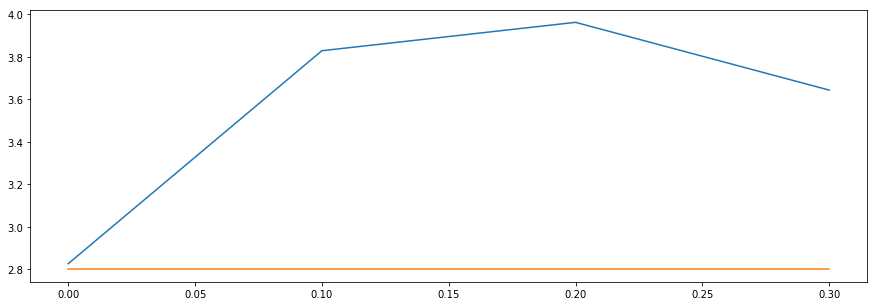

In [207]:
sim = hi_level(height = 4.2,angle=0.2*180,frequency=1)
trj = sim.load(read_trj=True)
plot_trj(trj)
plot_distance(trj)

In [138]:
def is_dimer(sim):
    sim.load()
    sim.lazy_read
    last_frame = max(list(sim.lazy_read.T.keys()))
    frame = sim.lazy_read.readframe(last_frame)

    p1 = frame[frame['id']==1]
    p2 = frame[frame['id']==2]
    distance = np.sqrt((p1['x']-p2['x'])**2+(p1['y']-p2['y'])**2+(p1['z']-p2['z'])**2)
    return (distance-sim.particle_properties[0].radius*2)<1.2

In [96]:
sim = hi_level(height = 5,angle=0)
is_dimer(sim)

array([False], dtype=bool)

In [199]:
height
0.4*180

72.0

## Phase Diagram

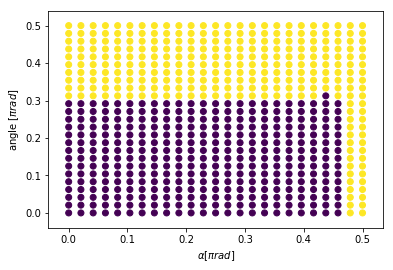

In [210]:
N = 25
alpha = np.linspace(0,90,N)
height = 2.8*np.cos(alpha/180*np.pi)+2.8
angle = np.linspace(0,90,N)

[H,A] = np.meshgrid(height,angle)

dimer_space_high = np.empty(np.shape(H)).flatten()

S = list(dimer_space_high);
for i,(h,a) in enumerate(zip(H.flatten(),A.flatten())):
    S[i] = hi_level(height = h, angle = a,frequency=10)
    d = is_dimer(S[i])
    if d.size>0:
        dimer_space_high[i]=d
    
alpha = np.arccos((H.flatten()-2.8)/2.8)
color = dimer_space_high.flatten()
color[color!=1] = 0
plt.scatter(alpha.flatten()/np.pi,A.flatten()/180,c=color.flatten())
plt.xlabel('$\\alpha [\pi rad]$')
plt.ylabel('angle $[\pi rad]$') 

## Phase space for low frequency (1Hz)

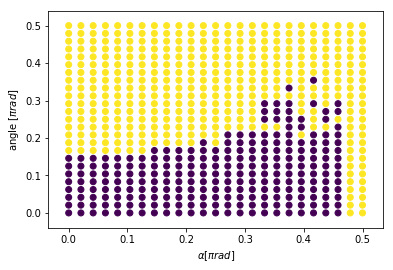

In [211]:
N = 25
alpha = np.linspace(0,90,N)
height = 2.8*np.cos(alpha/180*np.pi)+2.8
angle = np.linspace(0,90,N)

[H,A] = np.meshgrid(height,angle)

dimer_space_low = np.empty(np.shape(H)).flatten()
S = list(dimer_space_low);
for i,(h,a) in enumerate(zip(H.flatten(),A.flatten())):
    S[i] = hi_level(height = h, angle = a,frequency=1)
    d = is_dimer(S[i])
    if d.size>0:
        dimer_space_low[i]=d
    
alpha = np.arccos((H.flatten()-2.8)/2.8)
color = dimer_space_low.flatten()
color[color!=1] = 0
plt.scatter(alpha.flatten()/np.pi,A.flatten()/180,c=color.flatten())
plt.xlabel('$\\alpha [\pi rad]$')
plt.ylabel('angle $[\pi rad]$') 

# Support Functions

In [4]:
def plot_trj(trj):
    idx = pd.IndexSlice

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    for i in trj.index.get_level_values('id').unique():
        ax1.plot(trj.loc[idx[:,i],'x'],trj.loc[idx[:,i],'y'])
        ax2.plot(trj.loc[idx[:,i],'x'],trj.loc[idx[:,i],'z'])

    ax1.set(aspect='equal');
    ax2.set(aspect='equal');
    ax2.set_ylim([-5,5])

In [141]:
def plot_distance(trj, ax=None):
    idx = pd.IndexSlice
    if ax==None:
        fig, ax = plt.subplots(1,figsize=(15,5))
    
    ax.plot(trj.xs(1,level='id').t,
             np.sqrt((trj.loc[idx[:,1],'x'].values-trj.loc[idx[:,2],'x'].values)**2 + 
                    (trj.loc[idx[:,1],'y'].values-trj.loc[idx[:,2],'y'].values)**2 + 
                    (trj.loc[idx[:,1],'z'].values-trj.loc[idx[:,2],'z'].values)**2))
    ax.plot(trj.xs(1,level='id').t,trj.xs(1,level='id').index*0+2.8)
    return ax